In [19]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
import flash_attn

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [8]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [10]:
model_dir = Path("//samurlab1/Joshua/scGPT_models/")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab: 
        vocab.append_token(s)

with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from //samurlab1/Joshua/scGPT_models/best_model.pt, the model args will override the config //samurlab1/Joshua/scGPT_models/args.json.


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwis

In [15]:
import scanpy as sc
import anndata as ad
import numpy as np
import warnings as wrn

wrn.filterwarnings("ignore")

import pooch


In [23]:
adata = sc.read('/samurlab1/Joshua/h5ad/neuts.h5ad')
adata.obs['active.ident']

Myeloid_BM_234868_AAACCCAAGAGTCTTC-1       S100A8+LTF+imtr_neut
Myeloid_BM_234868_AAACCCAGTGAGGCAT-1    S100A8/9+MMP9+imtr_neut
Myeloid_BM_234868_AAACCCAGTTCTCCTG-1       Malat1+NCF1+mat_neut
Myeloid_BM_234868_AAACCCATCCCATTCG-1       Malat1+NCF1+mat_neut
Myeloid_BM_234868_AAACGCTAGGAGCAAA-1    S100A8/9+MMP9+imtr_neut
                                                 ...           
Myeloid_OL_551452_TTTGGTTCATGGCGCT-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGGTTTCATATGGC-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGAGACATATG-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGAGCTGCGAA-1      FCGR3B+CXCR2+mat_neut
Myeloid_OL_551452_TTTGTTGTCTAGTCAG-1      FCGR3B+CXCR2+mat_neut
Name: active.ident, Length: 84616, dtype: category
Categories (9, object): ['FCGR3B+CXCR2+mat_neut', 'S100A8+CD14+MAC', 'S100A8/9+MMP9+imtr_neut', 'LTF+CAMP+imtr_neut', ..., 'CXCL8+VEGFA+mat_neut', 'Malat1+NCF1+mat_neut', 'Mki67+DEFA3+pre-neut', 'HLA-DR+CD16+mac']

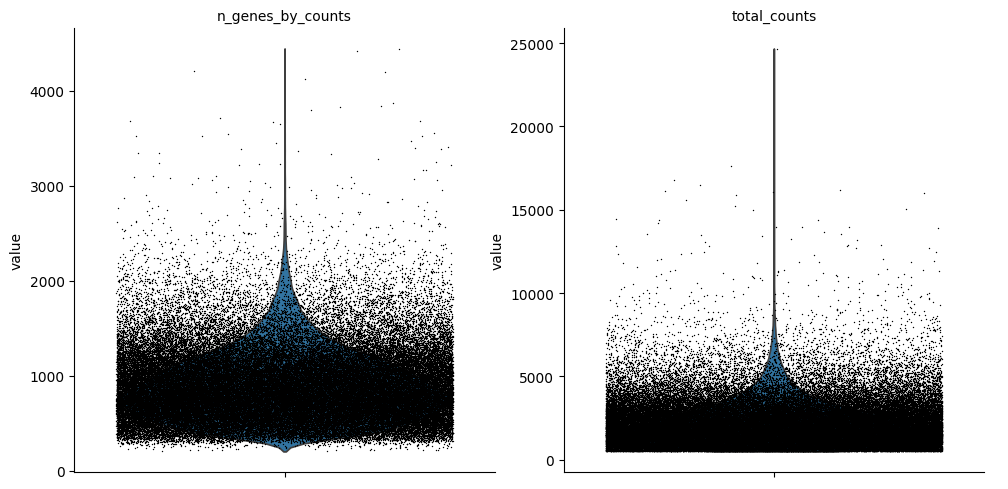

In [32]:
adata.var_names_make_unique()
adata.var

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

#mitrochondrial genes removal "MT-" for human, "Mt- for mouse"
adata.var["MT"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["MT"], percent_top=None, log1p=False, inplace=True
)
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL"))

sc.pl.violin(
    adata,
    ["n_genes_by_counts","total_counts"],
    jitter = 0.4,
    multi_panel = True
)



In [24]:
# Specify data path; here we load the Immune Human dataset
#data_dir = Path("/samurlab1/Joshua/h5ad")
#I have some data I already imported above so I will comment out above code
adata = sc.read(
    str(data_dir / "neuts.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["active.ident"].astype(str)
data_is_raw = False

In [45]:
print(adata.obs)


                                             orig.ident  nCount_RNA  \
Myeloid_BM_234868_AAACCCAAGAGTCTTC-1  Myeloid_BM_234868      1817.0   
Myeloid_BM_234868_AAACCCAGTGAGGCAT-1  Myeloid_BM_234868      2345.0   
Myeloid_BM_234868_AAACCCAGTTCTCCTG-1  Myeloid_BM_234868       795.0   
Myeloid_BM_234868_AAACCCATCCCATTCG-1  Myeloid_BM_234868       683.0   
Myeloid_BM_234868_AAACGCTAGGAGCAAA-1  Myeloid_BM_234868      2116.0   
...                                                 ...         ...   
Myeloid_OL_551452_TTTGGTTCATGGCGCT-1  Myeloid_OL_551452      2391.0   
Myeloid_OL_551452_TTTGGTTTCATATGGC-1  Myeloid_OL_551452      2981.0   
Myeloid_OL_551452_TTTGTTGAGACATATG-1  Myeloid_OL_551452      2584.0   
Myeloid_OL_551452_TTTGTTGAGCTGCGAA-1  Myeloid_OL_551452      2572.0   
Myeloid_OL_551452_TTTGTTGTCTAGTCAG-1  Myeloid_OL_551452      1802.0   

                                      nFeature_RNA  percent.mt  predicted  \
Myeloid_BM_234868_AAACCCAAGAGTCTTC-1           987    2.476610  CD14 M

In [46]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v5" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="celltype")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...


Exception: Version mismatch: this is the 'cffi' package version 1.15.0, located in '/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/cffi/api.py'.  When we import the top-level '_cffi_backend' extension module, we get version 1.17.1, located in '/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/_cffi_backend.cpython-310-x86_64-linux-gnu.so'.  The two versions should be equal; check your installation.